<a href="https://colab.research.google.com/github/geminiwaldo/CMP419-Weekly-Labs/blob/main/CMP419_lab4_text_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language and Vision Models

In this lab we explore two types of generative models: Text summarisation models (language-to-language) and image captioning models (vision-to-language).
Both are examples of pre-trained transformer-based models that generate natural language outputs.


All models used in this lab are:

Pre-trained.

Used without fine-tuning.

Run with default settings initially.

The goal is to understand how these systems behave before conducting deeper evaluation later.

In [1]:
import torch

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB\n")
else:
    print("No GPU detected. Code will run slowly on CPU.\n")

Using device: cuda
   GPU: Tesla T4
   Memory: 15.64 GB



# A. Text Summarisation

Text summarisation aims to produce a concise version of a longer document while preserving key information.
Each input sample consists of a document (or any text). The output is a more compact description of the information in the document.

Ideally, one or more reference (human-written) summaries exist for comparison.

In this lab we focus on abstractive summarisation, where the model generates new sentences rather than extracting them directly from the source text.



## Model

We will use a pre-trained `BART` BART (Bidirectional and Auto-Regressive Transformers) is a pre-trained sequence-to-sequence model designed for natural language generation tasks, including abstractive summarisation, translation, and text reconstruction.

Such models are trained on large summarisation datasets and use encoder-decoder architectures to generate summaries token by token.

Alternative models may be available (e.g. switching from BART to T5) to observe differences in behaviour. For now, we begin with a fixed baseline.

We will loads the pre-trained BART model and its tokenizer. The tokenizer converts text into tokens the model can understand, and the model itself is a sequence-to-sequence language model fine-tuned for summarisation tasks. The model is moved to the selected device (CPU or GPU) for computation.

In [ ]:
# run this ONLY if you get an error with loading the model.
# you must restart the runtime after instalaltion

# !pip install -U transformers

In [2]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn").to(device)

print("Model loaded successfully!\n")

KeyboardInterrupt: 

## Single Document Summarisation

We begin by generating a summary for a single "document."

In [ ]:
# Example article
sample_text = """
Artificial intelligence has made remarkable progress in recent years, with large language
models demonstrating capabilities that were once thought to be decades away. These models,
trained on vast amounts of text data, can now engage in complex reasoning, write code,
and even assist in scientific research. However, concerns remain about their reliability,
particularly when it comes to factual accuracy and the phenomenon known as "hallucination,"
where models confidently generate false information. Researchers are actively working on
methods to make these systems more trustworthy, including techniques for uncertainty
quantification and fact-checking. Meanwhile, the rapid development of multimodal models
that can process both text and images is opening new possibilities for applications in
healthcare, education, and creative industries. As these technologies continue to evolve,
questions about their societal impact, ethical use, and regulation are becoming
increasingly important.
"""
# the length of the entire text
print(f"Original Article ({len(sample_text.split())} words):")

reference_text = """
AI has advanced rapidly, with large language models (LLMs) now capable of
reasoning and coding. While "hallucinations" and reliability remain key
challenges, researchers are developing trust-building techniques like fact-checking.
Additionally, the rise of multimodal models is expanding AI's reach into sectors like
healthcare, while simultaneously raising critical ethical and regulatory questions
"""
# the length of the human summary
print(f"Human summary Article ({len(reference_text.split())} words):")

In [ ]:
# alternatively
# Read the sample text from file
# file_path = "sample_text.txt" # change path if needed

# with open(file_path, "r", encoding="utf-8") as f:
#     sample_text = f.read()

# # the entire content of file
# print(f"Original Article ({len(sample_text.split())} words):")
# print(sample_text)

The code encodes the sample text into token IDs, passes them through the BART model to generate a summary, and then decodes the output tokens back into human-readable text.

Text summarisation is controlled through parameters passed to the `model.generate`. Here, we do not pass other than the tokens so all settings are default.

In [ ]:
# Generate summary with default settings

inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True).to(device)
summary_ids = model.generate(**inputs)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(f"Summarised Article ({len(summary.split())} words):")
print(summary)

Summarised Article (57 words):
Artificial intelligence has made remarkable progress in recent years. But concerns remain about reliability,particularly when it comes to factual accuracy. Researchers are actively working on methods to make these systems more trustworthy. Meanwhile, the rapid development of multimodal modelsthat can process both text and images is opening new possibilities for applications in healthcare, education, and creative industries.


Does the summary capture the main points?

Is it shorter and more concise?

Does it introduce information not present in the original text?

Is the tone or structure different from the reference summary?

This baseline output will serve as a comparison point for later experiments.

## Change Parameters

Text generation depends on decoding settings. Common parameters include:

`Temperature`: controls randomness. Higher values increase variability.

`Top-p (nucleus sampling)`: restricts token selection to the most probable subset.

`Max length`: limits summary size.

`Beam search parameters`: influence determinism and search depth.

They can be passed as argument directly to the `model.generate` function. Do some research or look up examples. Modify one parameter and regenerate the summary. Observe how sensitive the summarisation is to decoding choices. It is useful to contemplate the text in terms of fluency, length, faithfulness to the source, and variability across runs.



# B. Image Captioning

This is a good example of the intersection of computer vision and natural language processing. Image caption models combine a vision encoder (e.g. CNN or Vision Transformer) and a language decoder (transformer-based).

Each input sample consists of an image. The output is a sequence of words describing the image content.

Ideally, one or more reference (human-annotated) captions exist for comparison.

## Model

We will use a pre-trained `BLIP` (Bootstrapping Language-Image Pre-training) model. It is a vision-language model designed for tasks such as image captioning, visual question answering, and image-text retrieval.

Such models are trained on large image-text datasets to extract visual features from the image and generate text conditioned on those features.

Alternative models may be available (e.g. switching from BLIP to BLIP-2, ViT-GPT2, or MiniGPT-4) to observe differences in behaviour. For now, we begin with a fixed baseline.

In [9]:
# needed packages
import requests # for URL
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration
import pandas as pd
import numpy as np

The codel loads the BLIP image captioning model and its processor. The processor handles image pre-processing and decoding, while the model generates captions for input images. The model is moved to the selected device (CPU or GPU).

In [3]:
# Load BLIP model and processor
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

print("Model loaded successfully!\n")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/473 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

The tied weights mapping and config for this model specifies to tie text_decoder.cls.predictions.bias to text_decoder.cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identic

Model loaded successfully!



## Single Image Captioning

Generate a caption for a single example image. Text generation in transformer models is controlled through decoding parameters passed to the `model.generate()` function.

In [ ]:
# Load example image
#image_url = "https://images.unsplash.com/photo-1583511655857-d19b40a7a54e?w=500"
#response = requests.get(image_url)
#sample_image = Image.open(BytesIO(response.content)).convert('RGB')

In [4]:
# alternatively
# Read image from a local file
image_file_path = "/content/drive/MyDrive/Colab Notebooks/coco_for_captioning" # change path if needed
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/coco_for_captioning/coco_image_captions.csv'
# sample_image = Image.open(image_file_path)

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
df = pd.read_csv(csv_file_path)
sample_df = df.sample(5)
captions = sample_df.groupby("file_name")["caption"].apply(list).to_dict()
print("Total images with captions:", len(captions))

Total images with captions: 5


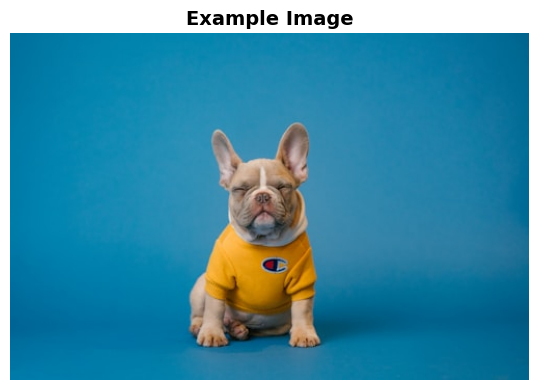

In [ ]:
# Display image
plt.figure(figsize=(6, 4))
plt.imshow(sample_image)
plt.axis('off')
plt.title("Example Image", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

The sample image is pre-processed for BLIP, which take the processed input and generates a caption using the default settings. It then decodes the output into readable text. The result is stored in caption_default.


Generating caption with default settings...


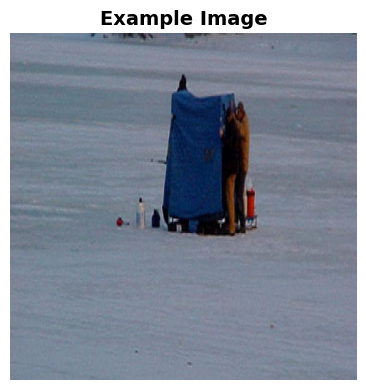


Generated Caption (Default):
   'a person sitting on a snow covered beach'
   '['Two men are about to enter an ice fishing tent on a snow covered lake .']'


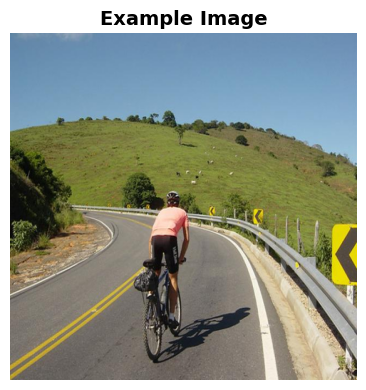


Generated Caption (Default):
   'a man riding a bike down a road'
   '['A cyclist is riding a bicycle on a curved road up a hill .']'


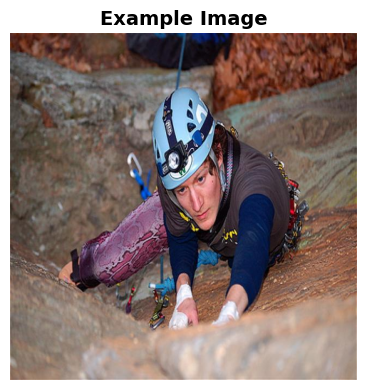


Generated Caption (Default):
   'a man climbing up a rock with a helmet on'
   '['A climber wearing a blue helmet and headlamp is attached to a rope on the rock face .']'


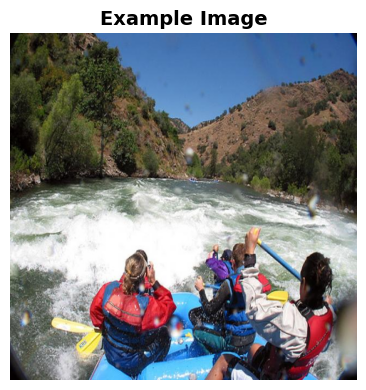


Generated Caption (Default):
   'a group of people in a raft raft'
   '['A group of people on a blue raft going down a river']'


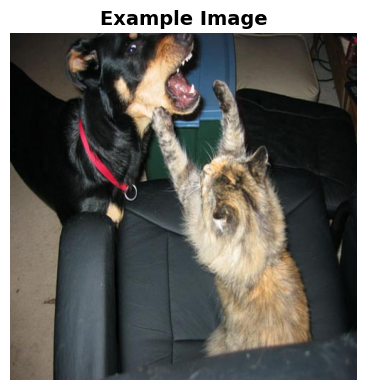


Generated Caption (Default):
   'a cat and dog are sitting on a chair'
   '['A dog and cat are fighting on a chair .']'


'\ninputs = blip_processor(sample_image, return_tensors="pt").to(device)\n\n# Default generation (greedy decoding)\noutputs = blip_model.generate(**inputs)\ncaption_default = blip_processor.decode(outputs[0], skip_special_tokens=True)\n\nprint(f"\nGenerated Caption (Default):")\nprint(f"   \'{caption_default}\'")\n'

In [7]:
# Generate caption with default settings
print("\nGenerating caption with default settings...")



generated = {}

for file_name in captions.keys():

  image_file = f"{image_file_path}/{file_name}"

  sample_image = Image.open(image_file).convert('RGB')

  inputs = blip_processor(sample_image, return_tensors="pt").to(device)

  outputs = blip_model.generate(**inputs)

  caption = blip_processor.decode(outputs[0], skip_special_tokens=True)

  generated[file_name] = caption

  plt.figure(figsize=(6, 4))
  plt.imshow(sample_image)
  plt.axis('off')
  plt.title("Example Image", fontsize=14, fontweight='bold')
  plt.tight_layout()
  plt.show()
  print(f"\nGenerated Caption (Default):")
  print(f"   '{caption}'")
  print(f"   '{captions[file_name]}'")


"""
inputs = blip_processor(sample_image, return_tensors="pt").to(device)

# Default generation (greedy decoding)
outputs = blip_model.generate(**inputs)
caption_default = blip_processor.decode(outputs[0], skip_special_tokens=True)

print(f"\nGenerated Caption (Default):")
print(f"   '{caption_default}'")
"""

In [18]:
#pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c8fee5b0e7a2fcd11c75b32c2b46ea3ddb0eb3e0b3c36a0d1bb0b40ad5bfb3e3
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [22]:
# Evaluation

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from rouge_score import rouge_scorer

rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

bleu_scores = []
rouge_scores = {key: [] for key in ['rouge1', 'rouge2', 'rougeL']}


index = 0
for file_name, gen_caption in generated.items():

  # get reference captions
  reference_captions = captions[file_name]
  split_reference_captions = [caption.split() for caption in reference_captions]

  split_gen_caption = gen_caption.split()

  # BLEU
  bleu = sentence_bleu(split_reference_captions, split_gen_caption)
  bleu_scores.append(bleu)

  # ROUGE
  rouge_img_score = rouge.score(reference_captions[0], gen_caption)
  for key in rouge_img_score:
        rouge_scores[key].append(rouge_img_score[key])

  print(f"\n\nImage Name: {file_name}\nReference Caption: {reference_captions}\nGenerated Caption: {gen_caption}")
  print("\nbleu score: {0}".format(round(bleu, 4)))
  print("\nrouge score: {0}".format(rouge_img_score))

  index += 1






Image Name: 103205630_682ca7285b_jpg.rf.0176e9ac7cf1dfcdb29a4f1813c99e5a.jpg
Reference Caption: ['Two men are about to enter an ice fishing tent on a snow covered lake .']
Generated Caption: a person sitting on a snow covered beach

bleu score: 0.1272

rouge score: {'rouge1': Score(precision=0.5, recall=0.26666666666666666, fmeasure=0.3478260869565218), 'rouge2': Score(precision=0.42857142857142855, recall=0.21428571428571427, fmeasure=0.2857142857142857), 'rougeL': Score(precision=0.5, recall=0.26666666666666666, fmeasure=0.3478260869565218)}


Image Name: 110595925_f3395c8bd6_jpg.rf.0596f9bef8d0ae07b364b1cc29bf5e88.jpg
Reference Caption: ['A cyclist is riding a bicycle on a curved road up a hill .']
Generated Caption: a man riding a bike down a road

bleu score: 0.0

rouge score: {'rouge1': Score(precision=0.625, recall=0.38461538461538464, fmeasure=0.4761904761904762), 'rouge2': Score(precision=0.14285714285714285, recall=0.08333333333333333, fmeasure=0.10526315789473685), 'rougeL

Does the caption describe the main objects?

Are important details missing?

Is the caption generic or specific?

Does it hallucinate objects that are not present?

Compare the generated caption to the reference caption.

## Change Parameters

As with text summarisation, caption generation depends on decoding settings such as: Temperature, Top-p, Max length, Beam width.

They can be passed as argument directly to the `model.generate` function. Do some research or look up examples.
Modify one parameter and regenerate the caption for the same image.
Compare outputs side by side.

Observe variability.

Note whether factual correctness changes.

Identify any hallucinations or instability.